# GEQIE IFRQI Example

## Setup

### Imports

In [17]:
import numpy as np
from PIL import Image, ImageOps

import matplotlib.pyplot as plt

In [18]:
import geqie
from geqie.encodings import ifrqi

## Encoding

### Opening the image

In [19]:
image = Image.open("../../assets/test_images/rgb/rgb4x4.png")
image = ImageOps.grayscale(image)
image = np.asarray(image)
image

array([[ 76,  76, 150, 226],
       [ 76, 226, 226,  75],
       [105,  29, 255, 119],
       [ 15,  15,   0,   0]], dtype=uint8)

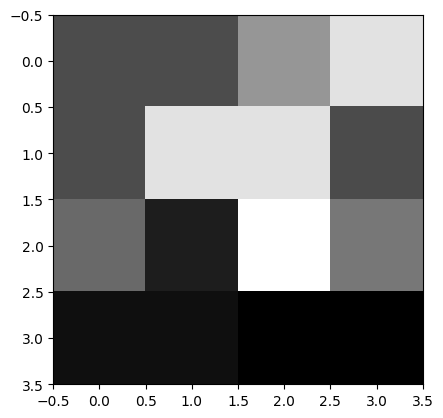

In [20]:
plt.imshow(image, cmap="gray")

### Encoding using unitary gate

In comparison to the FRQI method, in IFRQI we use 3 extra qubits for pixel’s intensity (in total 4 qubits). For image, which has pixels’ intensity level at $2^8$, we use 4 qubits to encode their level of intensity.

The map is as follows:
$$
\begin{bmatrix}
    b_0, b_1 | b_2, b_3 | b_4, b_5 | b_6, b_7 
\end{bmatrix}
\rightarrow
\ket{q_0 q_1 q_2 q_3}
$$

Where:

$\textbf{if } b_i, b_j == 00 \rightarrow \ket{q_i} = 100\%\ket{0}$

$\textbf{if } b_i, b_j == 01 \rightarrow \ket{q_i} = 65.45\%\ket{0} + 34.55\%\ket{1}$

$\textbf{if } b_i, b_j == 10 \rightarrow \ket{q_i} = 34.55\%\ket{0} + 65.45\%\ket{1}$

$\textbf{if } b_i, b_j == 11 \rightarrow \ket{q_i} = 100\%\ket{1}$

We achieve this with using $R_y$ gate rotation with angles: $0, \frac{2\pi}{10}, \frac{3\pi}{10}\text{, and }\frac{5\pi}{10}$.

General formula is: 

$$\ket{I_q} = \frac{1}{2^n} \sum_{i=0}^{2^{2n}-1} \left( \bigotimes_{k=0}^{p-1} \left( \cos\theta_{i,k}\ket{0} + \sin\theta_{i,k}\ket{1} \right) \right) \otimes \ket{i}$$




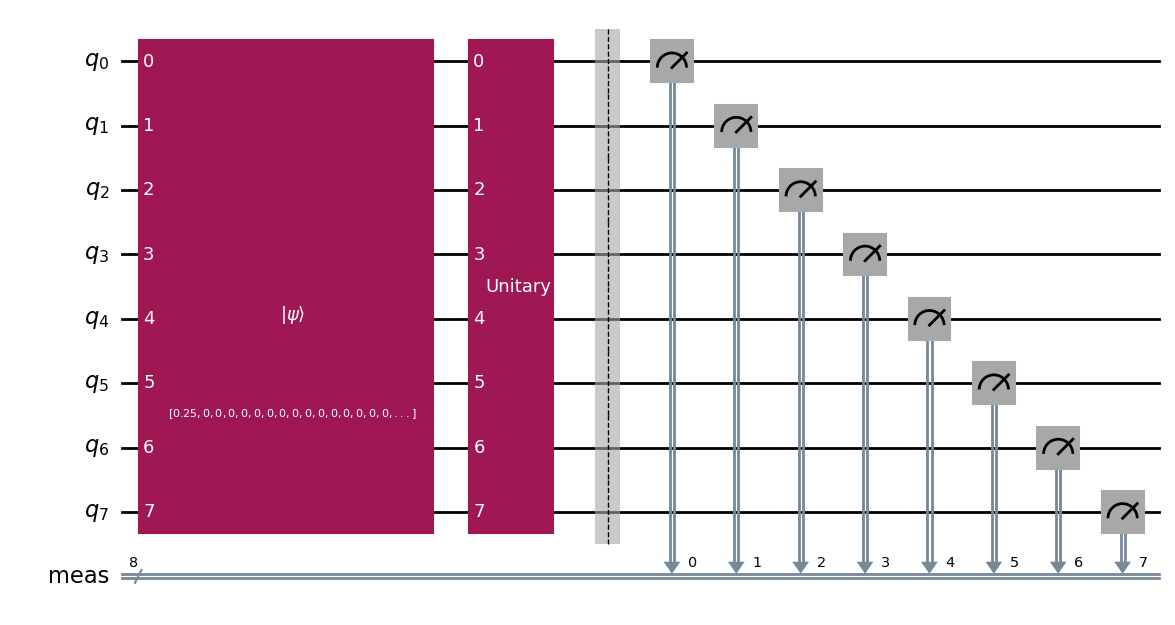

In [21]:
circuit = geqie.encode(
    ifrqi.init_function, ifrqi.data_function, ifrqi.map_function, image
)
circuit.draw(output="mpl")

### Simulating the circuit

In [22]:
result = geqie.simulate(circuit, 10000, return_padded_counts=True)
result = {key: result[key] for key in sorted(result)}

## Retrieving the image

Each shot is assigned to particular pixel. For each pixel, and for each of four qubits obtained from measurements we evaluate zeros and ones occurrence and we divide it through total shot-count for pixel. Please see code below:

In [23]:
reconstructed_image = np.zeros_like(image)
xy_index_div = int(np.log2(image.shape[0]))

reconstructed_image_counts_total = np.zeros((image.shape[0], image.shape[1]), dtype=int)
reconstructed_image_counts_ones = np.zeros(
    (image.shape[0], image.shape[1], 4), dtype=int
)

for state, n in result.items():
    x = state[0:xy_index_div]
    y = state[xy_index_div : 2 * xy_index_div]

    c = state[2 * xy_index_div : 2 * xy_index_div + 4][::-1]

    x_dec = int(x, base=2)
    y_dec = int(y, base=2)

    reconstructed_image_counts_total[x_dec, y_dec] += n

    for count in range(len(c)):
        if c[count] == "1":
            reconstructed_image_counts_ones[x_dec, y_dec, count] += n

for x in range(reconstructed_image_counts_ones.shape[0]):
    for y in range(reconstructed_image_counts_ones.shape[1]):
        color_bit_string = ""
        for c in range(4):
            coeff = (
                reconstructed_image_counts_ones[x, y, c]
                / reconstructed_image_counts_total[x, y]
            )
            if coeff > 0.75:
                color_bit_string += "11"
            elif 0.5 < coeff < 0.75:
                color_bit_string += "10"
            elif 0.25 < coeff < 0.5:
                color_bit_string += "01"
            elif coeff < 0.25:
                color_bit_string += "00"

        reconstructed_image[x, y] = int(color_bit_string[::-1], base=2)

print("Original image:")
print(image)
print("Retrieved image:")
print(reconstructed_image)

Original image:
[[ 76  76 150 226]
 [ 76 226 226  75]
 [105  29 255 119]
 [ 15  15   0   0]]
Retrieved image:
[[ 76  76 150 226]
 [ 76 226 226  75]
 [105  29 255 119]
 [ 15  15   0   0]]


### Reconstructed image

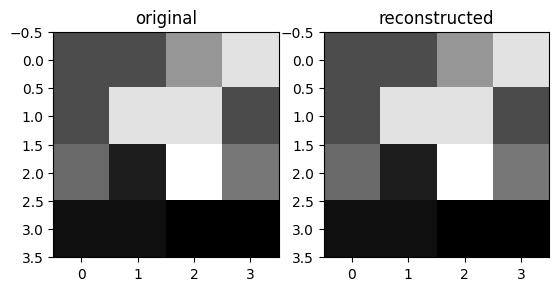

In [24]:
f = plt.figure()
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
ax.set_title("original")
ax.imshow(image, cmap="gray")

ax = f.add_subplot(gs[0, 1])
ax.set_title("reconstructed")
ax.imshow(reconstructed_image, cmap="gray")